# Imports

In [1]:
import os
import numpy as np
import torch
import pytorch_lightning as pl

from src.dataset.map_audio_dataset import MapAudioDataset
from src.datamodule.audio_data_module import AudioDataModule
from src.display.display_waveform import *

# Defentions

In [2]:
data_dir = os.path.join("..","..","data")

# Data

## Create DataModule Instance

In [3]:
datamodule = AudioDataModule(data_dir=data_dir,audio_dataset_class=MapAudioDataset)
datamodule.prepare_data()
datamodule.setup(stage='fit')
ref_batch_X,ref_batch_y = next(iter(datamodule.train_dataloader()))

100%|██████████| 2/2 [00:00<00:00, 1992.54it/s]


## Display sample data

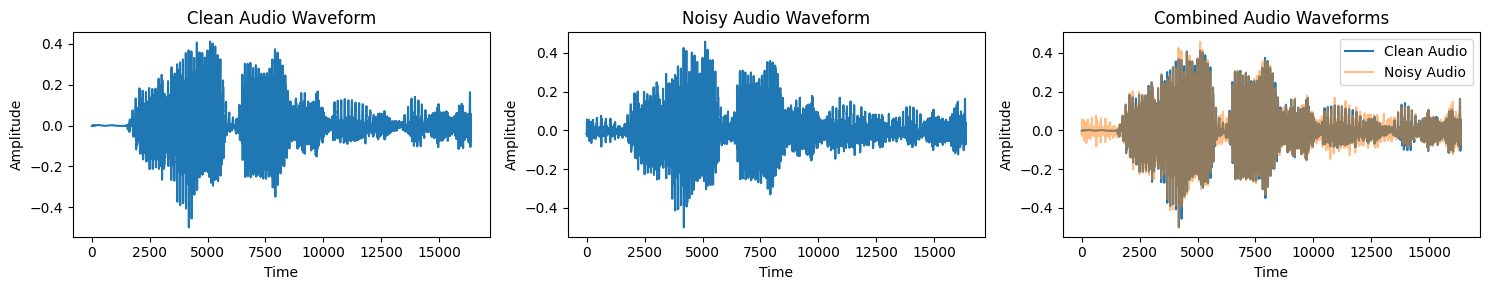

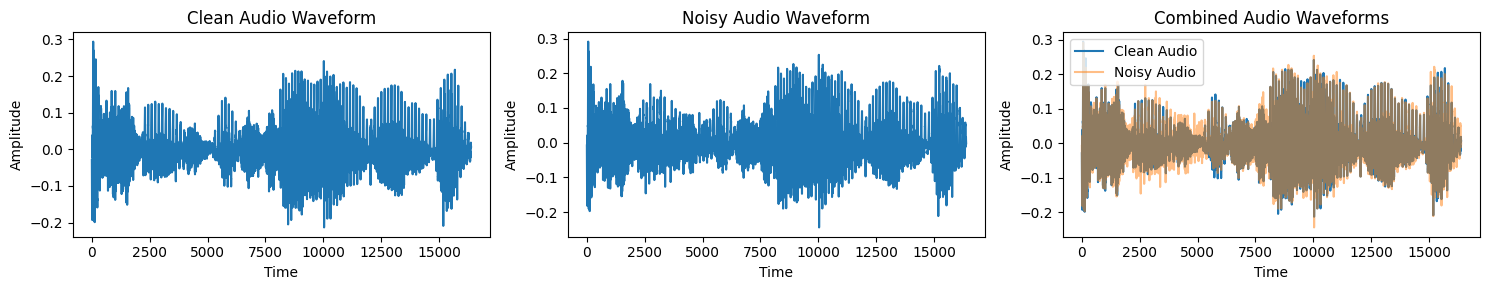

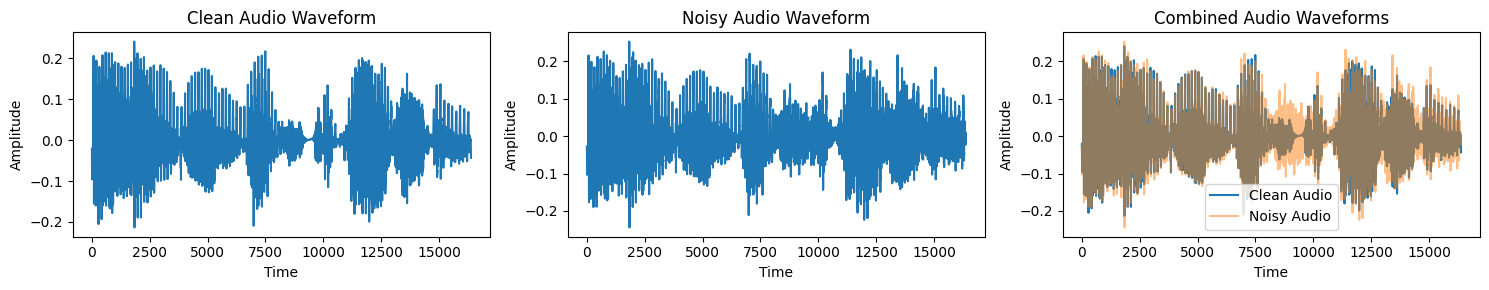

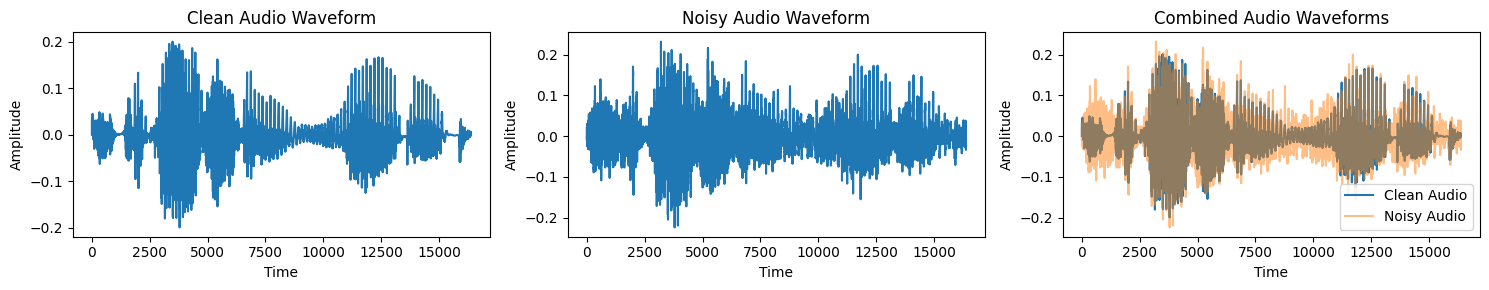

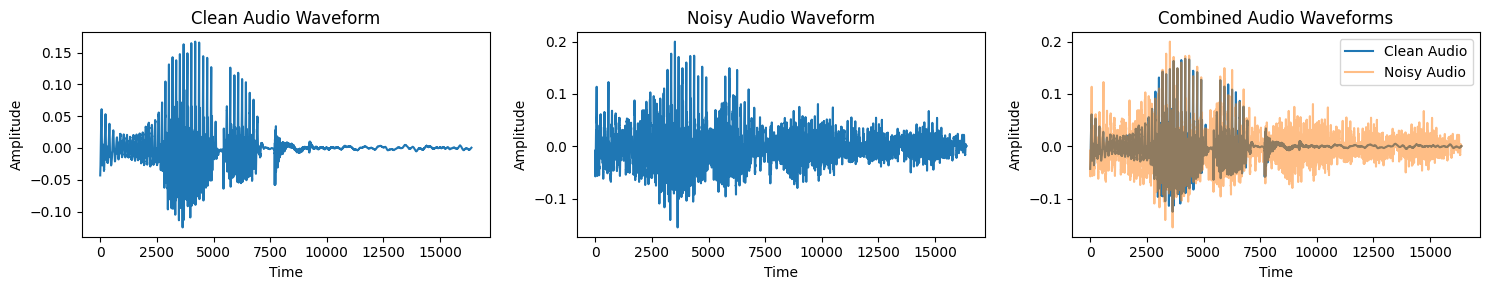

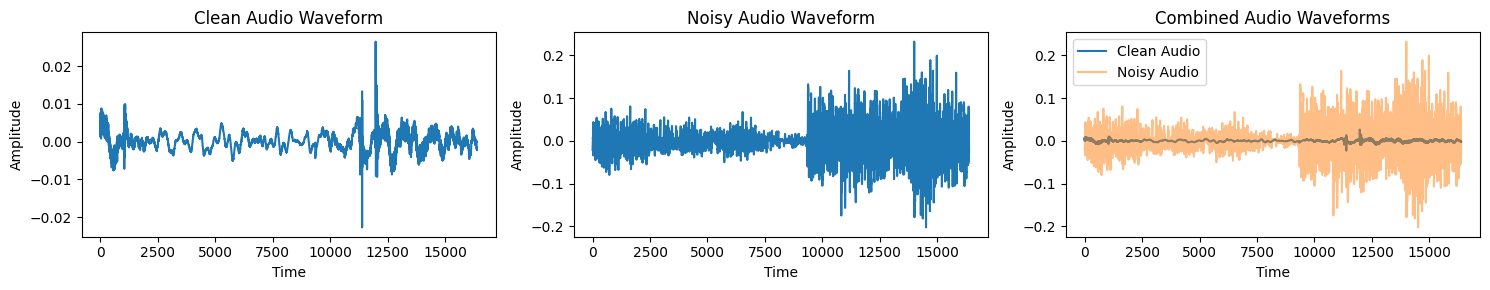

In [4]:
sample_size = 6
sample_index = np.random.randint(0, len(datamodule.train_dataset)-sample_size)
for i in range(sample_index,sample_index+sample_size):
    plot_waveforms(*datamodule.train_dataset[i])

# Net

In [5]:
from src.module.segan_generator import SEGAN_Generator
from src.module.segan_discriminator import SEGAN_Discriminator
from src.module.segan import SEGAN

generator = SEGAN_Generator()
discriminator = SEGAN_Discriminator(generator(ref_batch_X))
segan = SEGAN(generator,discriminator)

In [6]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar, DeviceStatsMonitor

# Callbacks
# checkpoint_callback = ModelCheckpoint(
#     monitor='val_loss',   # Metric to monitor
#     filename='segan-{epoch:02d}-{val_loss:.2f}',
#     save_top_k=3,         # Save the top 3 models
#     mode='min',           # Minimize the monitored metric (val_loss)
# )
# 
# early_stop_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=10,          # Number of epochs with no improvement after which training will be stopped
#     verbose=True,
#     mode='min'
# )
progress_bar_callback = TQDMProgressBar()
device_stats_callback = DeviceStatsMonitor()
callbacks = []

In [7]:
# Initialize the Trainer with callbacks
trainer = pl.Trainer(
    max_epochs=1,
    accelerator='gpu',
    log_every_n_steps=1,
    callbacks=callbacks,
)

# Start training
trainer.fit(segan, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Omer\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\Omer\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. T

TypeError: An invalid dataloader was passed to `Trainer.fit(train_dataloaders=...)`. Found <src.datamodule.audio_data_module.AudioDataModule object at 0x000002326CFEB370>.